In [2]:
import numpy as np
import pandas as pd

In [3]:
import pickle

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles 
from tqdm import tqdm

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

In [7]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif,SelectFromModel
from mrmr import mrmr_classif, mrmr_regression

In [8]:
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

In [9]:
df = pd.read_csv(r'C:\Users\USER\Downloads\final_df.csv')

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
df['is_canceled'].value_counts()

0    72476
1    42292
Name: is_canceled, dtype: int64

# Grid Search

In [28]:
df_test = df.sample(n = 100000)

In [29]:
X = df_test.iloc[:,:-1]

In [30]:
y = df_test.iloc[:,-1]

In [31]:
X_train, X_test, y_train,y_test = train_test_split(X, y, random_state = 42)

In [32]:
classifiers = [
    RandomForestClassifier(class_weight='balanced'),
    xgb.XGBClassifier(),
    SVC()]

In [33]:
scalers = [RobustScaler(),MinMaxScaler(),StandardScaler()]

In [34]:
lstresults = []
for scaler in tqdm(scalers):
    for classifier in tqdm(classifiers):
        pipe = Pipeline([
            ('scaler',scaler),
            ('feat_selection', SelectKBest(mutual_info_classif)),
            ('classifier', classifier)
        ])
        parameters = {
            'feat_selection__k':[i for i in range(15,30)]       
            }
        CV = GridSearchCV(pipe, parameters, 
                          scoring='f1_macro')
        CV.fit(X_train, y_train)
        a = classifier
        b = scaler
        c = CV.cv_results_['params']
        d = CV.cv_results_['mean_test_score']
        lstresults.append([a,b,c,d])

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:51<00:00, 137.05s/it]


In [35]:
lstresults

[[RandomForestClassifier(class_weight='balanced'),
  RobustScaler(),
  [{'feat_selection__k': 15},
   {'feat_selection__k': 16},
   {'feat_selection__k': 17},
   {'feat_selection__k': 18},
   {'feat_selection__k': 19},
   {'feat_selection__k': 20},
   {'feat_selection__k': 21},
   {'feat_selection__k': 22},
   {'feat_selection__k': 23},
   {'feat_selection__k': 24},
   {'feat_selection__k': 25},
   {'feat_selection__k': 26},
   {'feat_selection__k': 27},
   {'feat_selection__k': 28},
   {'feat_selection__k': 29}],
  array([0.75895853, 0.75640676, 0.75697787, 0.77274649, 0.767661  ,
         0.76023176, 0.76643779, 0.77139547, 0.77691824, 0.77689731,
         0.77301777, 0.77414265, 0.77648954, 0.77215228, 0.78525146])],
 [XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feat

In [36]:
res = pd.DataFrame(lstresults)
res = res.explode([2,3])

In [37]:
res

,0,1,2,3
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 15},0.758959
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 16},0.756407
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 17},0.756978
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 18},0.772746
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 19},0.767661
...,...,...,...,...
8,SVC(),StandardScaler(),{'feat_selection__k': 25},0.745145
8,SVC(),StandardScaler(),{'feat_selection__k': 26},0.763944
8,SVC(),StandardScaler(),{'feat_selection__k': 27},0.75399
8,SVC(),StandardScaler(),{'feat_selection__k': 28},0.759619


In [38]:
res.sort_values(3,ascending = False)

,0,1,2,3
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 29},0.785251
3,RandomForestClassifier(class_weight='balanced'),MinMaxScaler(),{'feat_selection__k': 26},0.783838
7,"XGBClassifier(base_score=None, booster=None, c...",StandardScaler(),{'feat_selection__k': 23},0.782319
6,RandomForestClassifier(class_weight='balanced'),StandardScaler(),{'feat_selection__k': 27},0.781232
6,RandomForestClassifier(class_weight='balanced'),StandardScaler(),{'feat_selection__k': 22},0.778772
...,...,...,...,...
5,SVC(),MinMaxScaler(),{'feat_selection__k': 20},0.690746
5,SVC(),MinMaxScaler(),{'feat_selection__k': 23},0.690698
5,SVC(),MinMaxScaler(),{'feat_selection__k': 15},0.690631
5,SVC(),MinMaxScaler(),{'feat_selection__k': 18},0.687665


In [47]:
pipe = Pipeline([
  ('scaler',RobustScaler()),
  ('feat_select', SelectKBest(mutual_info_classif,k=29)),
  ('classifier', RandomForestClassifier(random_state=42))
])

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
print(' - balanced accuracy:', round(balanced_accuracy_score(y_test, predictions),2))
print(' - macro f1:', round(f1_score(y_test, predictions, average='macro'),2))

 - balanced accuracy: 0.76
 - macro f1: 0.77


In [50]:
X_new = SelectKBest(score_func= mutual_info_classif, k=29).fit(X_train,y_train)

In [51]:
mask = X_new.get_support(indices=True)

In [52]:
mask

array([ 0,  5,  8,  9, 11, 12, 13, 14, 15, 17, 19, 26, 27, 31, 33, 35, 45,
       46, 47, 49], dtype=int64)

In [63]:
lstcolumns = X_train.columns

In [64]:
dic = {i:lstcolumns[i] for i in range(len(lstcolumns))}

In [65]:
dic

{0: 'lead_time',
 1: 'arrival_date_week_number',
 2: 'arrival_date_day_of_month',
 3: 'stays_in_weekend_nights',
 4: 'stays_in_week_nights',
 5: 'adults',
 6: 'children',
 7: 'babies',
 8: 'is_repeated_guest',
 9: 'previous_cancellations',
 10: 'previous_bookings_not_canceled',
 11: 'booking_changes',
 12: 'days_in_waiting_list',
 13: 'adr',
 14: 'required_car_parking_spaces',
 15: 'total_of_special_requests',
 16: 'hotel_City Hotel',
 17: 'hotel_Resort Hotel',
 18: 'meal_BB',
 19: 'meal_FB',
 20: 'meal_HB',
 21: 'meal_SC',
 22: 'meal_Undefined',
 23: 'market_segment_Aviation',
 24: 'market_segment_Complementary',
 25: 'market_segment_Corporate',
 26: 'market_segment_Direct',
 27: 'market_segment_Groups',
 28: 'market_segment_Offline TA/TO',
 29: 'market_segment_Online TA',
 30: 'distribution_channel_Corporate',
 31: 'distribution_channel_Direct',
 32: 'distribution_channel_GDS',
 33: 'distribution_channel_TA/TO',
 34: 'distribution_channel_Undefined',
 35: 'reserved_room_type_A',
 36:

In [66]:
importantkbest = [dic[i] for i in list(mask)]

In [67]:
importantkbest

['lead_time',
 'adults',
 'is_repeated_guest',
 'previous_cancellations',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel_Resort Hotel',
 'meal_FB',
 'market_segment_Direct',
 'market_segment_Groups',
 'distribution_channel_Direct',
 'distribution_channel_TA/TO',
 'reserved_room_type_A',
 'deposit_type_No Deposit',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'customer_type_Group']

In [12]:
importantkbest = list(X_train.columns)

NameError: name 'X_train' is not defined

# MRMR

In [40]:
df.columns

Index(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_City Hotel', 'hotel_Resort Hotel',
       'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined',
       'market_segment_Aviation', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'distribution_channel_Undefined',
       'reserved_room_type_A', 'reserved_room_type_B', 'reserved_room_type_C',
       'reserved_room_type_D

In [41]:
classifiers = [
    RandomForestClassifier(class_weight='balanced'),
    xgb.XGBClassifier(),
    SVC()]

In [42]:
results = []
for classifier in classifiers:
    clas = classifier
    for i in range(5,30):
        lst = (mrmr_classif(X_train,y_train.values,K=i))
        print(lst)
        X_train_temp = X_train.loc[:,lst]
        X_test_temp = X_test.loc[:,lst]
        clas.fit(X_train_temp, y_train)
        y_pred = classifier.predict(X_test_temp)
        a = len(lst)
        b = lst
        c = str(classifier)
        d = balanced_accuracy_score(y_test, y_pred)
        e = f1_score(y_test, y_pred, average='macro')
        results.append([a,b,c,d,e])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.72it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests']


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.36it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.75it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes']


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 33.86it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups']


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.71it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct']


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.84it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations']


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.20it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel']


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.44it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct']


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.43it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party']


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 34.18it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest']


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.14it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D']


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.80it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month']


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 30.97it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel']


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.79it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.62it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB']


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.67it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list']


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.49it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate']


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.32it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable']


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.40it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled']


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.23it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary']


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 32.62it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate']


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.04it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A']


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.14it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A', 'adults']


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.07it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A', 'adults', 'market_segment_Aviation']


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.34it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A', 'adults', 'market_segment_Aviation', 'meal_HB']


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.48it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests']


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.65it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 27.58it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes']


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.62it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups']


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.51it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct']


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.05it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations']


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 28.12it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel']


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.37it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct']


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.35it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party']


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.05it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest']


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 29.96it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D']


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31.96it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month']


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 27.88it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel']


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 31.12it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 27.07it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB']


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.86it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list']


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 31.11it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate']


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 32.71it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable']


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.42it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled']


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 30.11it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary']


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.19it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate']


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 31.33it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A']


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 28.33it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A', 'adults']


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 31.45it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A', 'adults', 'market_segment_Aviation']


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.96it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A', 'adults', 'market_segment_Aviation', 'meal_HB']


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.80it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests']


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 36.95it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.83it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes']


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 35.98it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups']


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.34it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct']


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.12it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations']


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.82it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel']


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.58it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct']


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.74it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party']


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 34.48it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest']


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.13it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D']


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.92it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month']


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.61it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel']


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 31.96it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 30.31it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB']


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.02it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list']


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.36it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate']


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.40it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable']


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.35it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled']


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.50it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary']


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.12it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate']


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 31.88it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A']


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.24it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A', 'adults']


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.20it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A', 'adults', 'market_segment_Aviation']


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.97it/s]


['deposit_type_No Deposit', 'required_car_parking_spaces', 'deposit_type_Non Refund', 'lead_time', 'total_of_special_requests', 'distribution_channel_TA/TO', 'booking_changes', 'market_segment_Groups', 'distribution_channel_Direct', 'previous_cancellations', 'hotel_City Hotel', 'market_segment_Direct', 'customer_type_Transient-Party', 'is_repeated_guest', 'reserved_room_type_D', 'arrival_date_day_of_month', 'hotel_Resort Hotel', 'customer_type_Transient', 'meal_FB', 'days_in_waiting_list', 'market_segment_Corporate', 'deposit_type_Refundable', 'previous_bookings_not_canceled', 'market_segment_Complementary', 'distribution_channel_Corporate', 'reserved_room_type_A', 'adults', 'market_segment_Aviation', 'meal_HB']


In [43]:
res = pd.DataFrame(results)

In [44]:
res

,0,1,2,3,4
0,5,"[deposit_type_No Deposit, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.663387,0.664173
1,6,"[deposit_type_No Deposit, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.674618,0.675462
2,7,"[deposit_type_No Deposit, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.684253,0.686550
3,8,"[deposit_type_No Deposit, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.678514,0.679482
4,9,"[deposit_type_No Deposit, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.672439,0.673070
...,...,...,...,...,...
70,25,"[deposit_type_No Deposit, required_car_parking...",SVC(),0.594008,0.575920
71,26,"[deposit_type_No Deposit, required_car_parking...",SVC(),0.594008,0.575920
72,27,"[deposit_type_No Deposit, required_car_parking...",SVC(),0.594008,0.575920
73,28,"[deposit_type_No Deposit, required_car_parking...",SVC(),0.594008,0.575920


In [45]:
res.sort_values(4,ascending = False)

,0,1,2,3,4
23,28,"[deposit_type_No Deposit, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.738933,0.745349
18,23,"[deposit_type_No Deposit, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.735204,0.740820
17,22,"[deposit_type_No Deposit, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.734744,0.740003
45,25,"[deposit_type_No Deposit, required_car_parking...","XGBClassifier(base_score=None, booster=None, c...",0.732689,0.739087
15,20,"[deposit_type_No Deposit, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.733026,0.738348
...,...,...,...,...,...
55,10,"[deposit_type_No Deposit, required_car_parking...",SVC(),0.577623,0.554957
54,9,"[deposit_type_No Deposit, required_car_parking...",SVC(),0.577623,0.554957
53,8,"[deposit_type_No Deposit, required_car_parking...",SVC(),0.577623,0.554957
52,7,"[deposit_type_No Deposit, required_car_parking...",SVC(),0.577623,0.554957


In [68]:
importantmrmr = res.iloc[23,1]

In [69]:
importantmrmr

['deposit_type_No Deposit',
 'required_car_parking_spaces',
 'deposit_type_Non Refund',
 'lead_time',
 'total_of_special_requests',
 'distribution_channel_TA/TO',
 'booking_changes',
 'market_segment_Groups',
 'distribution_channel_Direct',
 'previous_cancellations',
 'hotel_City Hotel',
 'market_segment_Direct',
 'customer_type_Transient-Party',
 'is_repeated_guest',
 'reserved_room_type_D',
 'arrival_date_day_of_month',
 'hotel_Resort Hotel',
 'customer_type_Transient',
 'meal_FB',
 'days_in_waiting_list',
 'market_segment_Corporate',
 'deposit_type_Refundable',
 'previous_bookings_not_canceled',
 'market_segment_Complementary',
 'distribution_channel_Corporate',
 'reserved_room_type_A',
 'adults',
 'market_segment_Aviation']

In [13]:
importantkbest

NameError: name 'importantkbest' is not defined

In [ ]:
set2 = set(importantmrmr) & set(importantkbest)

In [ ]:
venn2(subsets=(len(importantmrmr), len(importantkbest), len(set2)),  
      set_labels=('MRMR Important', 'Select K Best Important'), 
      set_colors=("orange", "blue"), alpha=0.7) 
  
# add outline 
venn2_circles(subsets=(len(importantmrmr), len(importantkbest), len(set2)),  
              linestyle="dashed",  
              linewidth=2) 
  
# assign title of the venn diagram 
plt.title("Venn Diagram in Feature Importance")   
plt.show() 

In [70]:
finalmodel = Pipeline([
  ('scaler',RobustScaler()),
  ('feat_select', SelectKBest(mutual_info_classif,k=29)),
  ('classifier', RandomForestClassifier(random_state=42))
])

finalmodel.fit(X_train, y_train)
predictions = finalmodel.predict(X_test)
print(' - balanced accuracy:', round(balanced_accuracy_score(y_test, predictions),2))
print(' - macro f1:', round(f1_score(y_test, predictions, average='macro'),2))

 - balanced accuracy: 0.76
 - macro f1: 0.77


In [72]:
cnf_matrix = confusion_matrix(predictions, y_test)
cnf_matrix

array([[422, 116],
       [ 37, 175]], dtype=int64)

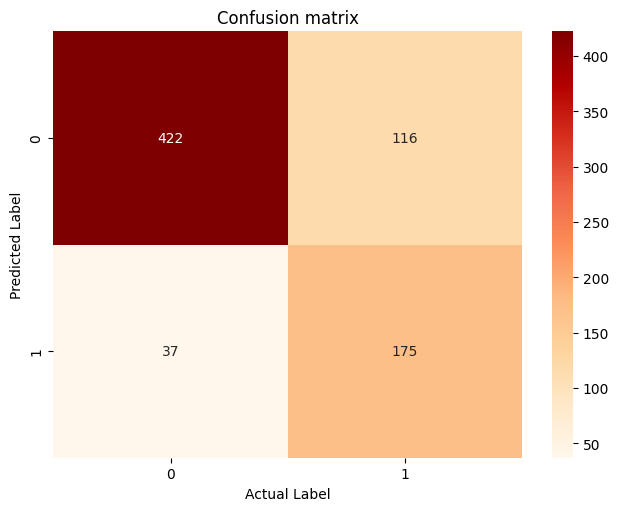

In [74]:
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#Create Heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot= True, cmap = "OrRd", fmt ="g")
plt.tight_layout()
plt.title("Confusion matrix")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
None